<a href="https://colab.research.google.com/github/iamsurajkumar/Empirical-Macroeconomics/blob/main/stock_market_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (Sample code) Large language models: a primer for economists


This repository accompanies our paper, **“Large language models: a primer for economists”**, authored by Byeungchun Kwon, Taejin Park, Fernando Perez-Cruz, and Phurichai Rungcharoenkitkul.

The publication provides an accessible introduction to LLMs aimed at economists and offers applied researchers a practical walkthrough of their use. You can access the full paper [here](https://www.bis.org/publ/qtrpdf/r_qt2412b.htm).

**Repository Overview**

Due to restrictions on the proprietary data used in the original research, this repository utilises a different sample dataset from ArXiv, which is open-source and features topics unrelated to the original study. Additionally, to minimise computational demands, we employ smaller datasets and models for illustration purposes. While the procedures outlined below closely mirror the actual analysis, the data, models, examples, and outcomes presented here differ from those in the paper.

**Original Study Summary**

In the original study, we analysed 63,388 daily news articles from proprietary sources spanning 2021–2023, a period marked by sharp monetary policy tightening and rising inflation. We identify the perceived drivers of stock market prices, classifying them into three categories:

1. **Fundamentals**: Current and expected future dividends.
2. **Monetary Policy**: The discount rate.
3. **Market Sentiment**: Investor risk appetite and sentiment.

Sentiment analysis further classified topics as negative, neutral, or positive, with positive sentiment indicating a potential association with stock price increases.



### Process Overview


  ![Overall Chart](https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/img/overallchart.jpg?raw=1)


  This notebook represents a detailed workflow for analyzing papers about genomics published between 2000 and 2024. The process involves several steps, categorized into data organization, signal extraction, and quantitative analysis:

  1. **Data Collection:**
    - Genomics Papers during 2000–24:
      - A total of 1,000 genomics papers are collected for analysis.
    - 100-Word Texts:
      - The papers are broken down into 1,179 chunks, each containing approximately 100 words.

  2. **Data Organization:**
    - Tokenisation & Embedding:
      - The text chunks undergo tokenization and embedding using Microsoft Phi 3 mini.

  3. **Signal Extraction:**
    - Topic Modelling:
      - Topic modeling is performed using BERTopic and KeyBERT, resulting in the identification of 25 topics.
    - Topic Grouping:
      - The 25 topics are further grouped using Latent Dirichlet Allocation (LDA) into 5 broader topics.

  4. **Quantitative Analysis:**
    - Sentiment Classification:
      - Sentiment classification is applied to the text chunks.
    - Sentiment Analysis by Topic:
      - Finally, sentiment analysis is conducted for each of the 5 topics.

### Python package installation

In [ ]:
!pip install --quiet -r https://raw.githubusercontent.com/bis-med-it/LLM_Primer_for_Economists/main/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.8/447.8 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import re
import json
import requests
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

pd.set_option('display.max_colwidth', 1000)  # Display full content of columns


### Data processing

<img src="https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/img/dataprocessing.jpg?raw=1" alt="Overall Chart" width="600px">

#### Parameters

- **`arxiv_jsonfile`**: URL pointing to the JSON file containing the titles and summaries of 1,000 genomics research papers from ArXiv.

- **`word_chunk_size`**: Specifies the size of word chunks used in the topic model. Smaller values may capture more fine-grained themes, while larger values tend to generalize the topics.

- **`embeddingmodel`**: Defines the Hugging Face embedding model used for text representation. `'microsoft/Phi-3-mini-4k-instruct'` is a pre-trained model optimized for NLP tasks. You can replace this with any other text generation model available on Hugging Face to suit your needs.



In [ ]:
arxiv_jsonfile = r'https://github.com/bis-med-it/LLM_Primer_for_Economists/blob/main/arxiv.json?raw=true'
word_chunk_size = 100
embeddingmodel = 'microsoft/Phi-3-mini-4k-instruct'


#### Genomics paper loading

In [ ]:
# Fetch the data from the URL
response = requests.get(arxiv_jsonfile)
response.raise_for_status()  # Raise an exception for bad status codes

# Load the JSON data
data = json.loads(response.text)
dfarxiv = pd.DataFrame(data)

In [ ]:
dfarxiv.head()

,year,title,summary
0,1996,A Growth model for DNA evolution,A simple growth model for DNA evolution is introduced which is analytically\nsolvable and reproduces the observed statistical behavior of real sequences.\n
1,2000,Symmetry Analysis Of Genetic Code And Determinative Degree (in Russian),"A three-dimensional model of the genetic vocabulary is proposed in terms of\ndeterminative degree, an introduced characteristic of nucleotide, which\nreflects absolute difference between purin and pyrimidin bases in one DNA\nstrand. In the fremework of this model manifest symmetry and group properties\nare described. It is proposed to use the determinative degree of codons to\nanalyze genetic texts, and to explain the biological sense of various\nfunctional regions of DNA.\n"
2,2001,Self-organizing Approach for Automated Gene Identification in Whole\n Genomes,An approach based on using the idea of distinguished coding phase in explicit\nform for identification of protein-coding regions (exons) in whole genome has\nbeen proposed. For several genomes an optimal window length for averaging\nGC-content function and calculating codon frequencies has been found.\nSelf-training procedure based on clustering in multidimensional space of\ntriplet frequencies is proposed. For visualization of data in the space of\ntriplet requiencies method of elastic maps was applied.\n
3,2002,On the Hypercube Structure of the Genetic Code,"A representation of the genetic code as a six-dimensional Boolean hypercube\nis proposed. It is assumed here that this structure is the result of the\nhierarchical order of the interaction energies of the bases in codon-anticodon\nrecognition. The proposed structure demonstrates that in the genetic code there\nis a balance between conservatism and innovation. Comparing aligned positions\nin homologous protein sequences two different behaviors are found: a) There are\nsites in which the different amino acids present may be explained by one or two\n""attractor nodes"" (coding for the dominating amino acid(s)) and their one-bit\nneighbors in the codon hypercube, and b) There are sites in which the amino\nacids present correspond to codons located in closed paths in the hypercube.\nThe structure of the code facilitates evolution: the variation found at the\nvariable positions of proteins do not corresponds to random jumps at the codon\nlevel, but to well defined regions of the hypercub..."
4,2002,"Entropy, Transinformation and Word Distribution of Information-Carrying\n Sequences","We investigate correlations in information carriers, e.g. texts and pieces of\nmusic, which are represented by strings of letters. For information carrying\nstrings generated by one source (i.e. a novel or a piece of music) we find\ncorrelations on many length scales. The word distribution, the higher order\nentropies and the transinformation are calculated. The analogy to strings\ngenerated through symbolic dynamics by nonlinear systems in critical states is\ndiscussed.\n"


#### Tokenization & Chunking

In [ ]:
# Preprocess document content and generate text chunks for analysis
# - docs: List to store unique text chunks extracted from the documents
# - df_docs_mapper: List to map the original text ID to generated document chunks
# - docs_cnt: Counter to assign unique IDs to document chunks

# Initialize variables for document processing
docs = []
df_docs_mapper = []
docs_cnt = 0

# Iterate through each record in the DataFrame and generate text chunks
for i, rec in tqdm(dfarxiv.iterrows(), total=len(dfarxiv)):
    text = rec['summary']
    text2 = re.sub(r'[\.\n]', ' ', text)  # Replace periods and newlines with space
    text2 = re.sub(r'\s+', ' ', text2)  # Replace multiple spaces with a single space
    text2 = re.sub(r'[^a-zA-Z0-9 ]', '', text2).strip()  # Remove non-alphanumeric characters
    words = text2.split()

    # Create word chunks from the cleaned text
    word_idx = 0
    while word_idx < len(words):
        word_piece = words[word_idx: word_idx + word_chunk_size]
        is_piece_chunksize = len(word_piece) == word_chunk_size
        chunk_text = ' '.join(word_piece)

        # Add unique chunks to docs and update the document mapper
        if is_piece_chunksize and chunk_text not in docs:
            docs.append(chunk_text)
            df_docs_mapper.append((i, docs_cnt))
            docs_cnt += 1
        word_idx = word_idx + word_chunk_size

# Convert document mapper list to DataFrame and merge with document chunks
df_docs_mapper = pd.DataFrame(df_docs_mapper, columns=['text_id', 'doc_id'])
df_docs = df_docs_mapper.merge(pd.DataFrame(docs), left_index=True, right_index=True)

100%|██████████| 1000/1000 [00:00<00:00, 11818.44it/s]


In [ ]:
print(f'Total number of pages: {len(df_docs_mapper.text_id.drop_duplicates())}, total number of chunks (each chunk contains {word_chunk_size} words): {len(docs)}')

Total number of pages: 847, total number of chunks (each chunk contains 100 words): 1179


In [ ]:
chunk_stat = df_docs_mapper.groupby('text_id').count().describe()
print(f'For each page, the average number of chunks is: {chunk_stat.iloc[1,0]:.2f}, with a minimum of {chunk_stat.iloc[3,0]} chunks and a maximum of {chunk_stat.iloc[7,0]} chunks.')

For each page, the average number of chunks is: 1.39, with a minimum of 1.0 chunks and a maximum of 3.0 chunks.


#### Process for Removing Outlier Documents

- Remove outlier documents by filtering out those with a number of chunks greater than the 75th percentile of the average chunk count across all documents.
- Calculate the cutoff value, identify valid articles with chunks below this threshold, and filter the documents accordingly.


In [ ]:

num_chunk_per_article_cufoff = chunk_stat.loc['75%'][0]
doc_cnt_per_article = df_docs_mapper.groupby('text_id').count()

print(f'Cutoff chunk size per article: {num_chunk_per_article_cufoff}')

valid_article_id = doc_cnt_per_article[doc_cnt_per_article['doc_id'] <= num_chunk_per_article_cufoff].index.to_list()
df_docs_mapper = df_docs_mapper[df_docs_mapper.text_id.isin(valid_article_id)]
valid_docs_id = df_docs_mapper.doc_id.to_list()

print(f'valid number of article, docs: {len(valid_article_id)}, {len(valid_docs_id)}')

Cutoff chunk size per article: 2.0
valid number of article, docs: 845, 1173


In [ ]:
# Merge document chunks with mapper and publication dates
# - df_docs: DataFrame that contains document chunks, their corresponding IDs, and publication dates

# Merge document chunks with document mapper DataFrame
df_docs = df_docs_mapper.merge(pd.DataFrame(docs), how='inner', left_on='doc_id', right_index=True)
df_docs.columns = ['text_id', 'doc_id', 'chunk']

### Embedding (Microsoft Phi-3 Mini)

- **Purpose**: Generate sentence embeddings using a pre-trained language model.
- **get_sentence_embedding**: A function that generates the embedding for a given sentence using a tokenizer and model.
- **embeddings**: A list to store the embeddings for all documents in the dataset.
- **CPU vs. GPU**:
  - If the code is executed on a **CPU**, it loads precomputed embeddings from a JSON file hosted on GitHub because CPU performance is slower for embedding generation, making real-time processing inefficient.
  - If on **GPU**, it calculates embeddings in real-time using the specified model and tokenizer.

- **get_sentence_embedding Function**:
  - Takes a sentence as input, tokenizes it, and passes it through the model.
  - Extracts the last hidden state and computes the mean to produce the sentence embedding.

- **Final Step**: Converts the embeddings list into a numpy array for further processing.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cpu':
  import io
  npzfileurl = 'https://github.com/bis-med-it/LLM_Primer_for_Economists/blob/main/embeddings_arxiv_msphi3.npz?raw=true'
  response = requests.get(npzfileurl)
  response.raise_for_status()  # Check for errors
  with np.load(io.BytesIO(response.content)) as data:
    embeddings = data['array']
else:
  llm_engine = AutoModel.from_pretrained(
      embeddingmodel,
      device_map= 'auto',
      torch_dtype=torch.float16,
  ).to(device)
  tokenizer = AutoTokenizer.from_pretrained(embeddingmodel)

  def get_sentence_embedding(sentence):
      inputs = tokenizer(sentence, return_tensors='pt').to(device)
      with torch.no_grad():
          outputs = llm_engine(**inputs)
      last_hidden_state = outputs.last_hidden_state
      sentence_embedding = torch.mean(last_hidden_state, dim=1).squeeze().tolist()
      return sentence_embedding

  embeddings = [get_sentence_embedding(doc) for doc in tqdm(docs)]
  embeddings = np.array(embeddings)

# (Optional) save embeddings to npz file
# np.savez_compressed('embeddings_arxiv_msphi3.npz', array=embeddings)

### Topic Modelling

<img src="https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/img/topicmodelling.jpg?raw=1" alt="Topic modelling" width="600px">

#### BERTopic modelling

- **Top Words (`num_top_words`):** Number of key terms per topic.
- **KeyBERT Words (`num_keybert_words`):** Words representing each topic using KeyBERT.
- **Topic Limit (`topic_limit`):** Maximum number of topics.

In [ ]:
num_top_words = 30
num_keybert_words = 10
topic_limit = 20
min_cluster_size = 10
n_gram_range = (1, 3)

representation_model = {"KeyBERT": KeyBERTInspired(top_n_words=num_keybert_words, nr_repr_docs=20)}
vectorizer_model = CountVectorizer(stop_words="english")

# Step 1 - Extract embeddings
embedding_model = 'sentence-transformers/all-MiniLM-L6-v2'

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=5,  # Neighboring sample points (Increasing means more global view)
                  n_components=10, # Reduced dimensions of the embeddings
                  min_dist=0.0,
                  metric='euclidean')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english",  # Removes stopwords
                                    ngram_range=n_gram_range)  # No. of words in a topic

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = {
  "KeyBERT": KeyBERTInspired(
    top_n_words=15,  # The top n words to extract per topic (default 10)
    nr_repr_docs=12,  # The number of representative documents to extract per cluster (default 5)
    nr_samples=300  # The number of candidate documents to extract per cluster (default 500)
  )
}

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  n_gram_range=n_gram_range                 # No. of words per topic
)
# Fit and transform the model on the documents and embeddings
topics, initial_probabilities = topic_model.fit_transform(docs, embeddings)

# Create a DataFrame with the topics and their corresponding probabilities
df_results = pd.DataFrame({'Topic': topics, 'Probability': initial_probabilities})

# Get detailed topic information from the BERTopic model and merge with the results DataFrame
df_topic_info = topic_model.get_topic_info()
df_results = df_results.merge(df_topic_info, how='left', on='Topic')

# Merge document mapper with results DataFrame and filter out documents without topics
embedding_list = [list(val) for val in embeddings]
df_results = df_docs_mapper.merge(df_results, how='left', left_on='doc_id', right_index=True)
df_bertopic_results = df_results[df_results.Topic != -1.0].dropna(how='any').reset_index(drop=True)

In [ ]:
df_results['KeyBERT'] = df_results['KeyBERT'].apply(tuple)
topic_keybert_counts = df_results.groupby(['Topic', 'KeyBERT']).size().reset_index(name='counts')
topic_keybert_counts

,Topic,KeyBERT,counts
0,-1,"(structures interphase chromatin, interphase chromatin, hesc genome, genomewide proximity placement, initiation dna, regulatory structures interphase, initiation dna replication, genomewide proximity, chromatin, genome, genomewide, genomic coordinates, dna replication, genomic loci, genomic)",11
1,0,"(genomes, genome, genomic, genes, gene expression, gene, rna, sequencing, rnaseq, genetic, dna, mutations, mrna, nucleotide, datasets)",1007
2,1,"(proteomics analysis, proteomics, gel electrophoresis, proteomics longer, analysis proteins, protein detection, electrophoresis, proteomic, word proteomics, twodimensional electrophoresis, membrane proteins, protein solubility, proteins, sds electrophoresis, electrophoretic separations)",31
3,2,"(immune repertoires, repertoire sequencing, antibody repertoires, immunogenomics, adaptive immune, receptor tcr, tcr sequences, tcell receptor, repertoire construction, tcell receptors, repertoire, repertoires, immune response, sequencing, immunosequencing)",27
4,3,"(coronaviruses, coronavirus, sarscov2, covid19 pandemic, virusseq, genomic surveillance, covid19, genome sequences, merbecovirus, covid19 caused, viral, genome, genomic, genomes, viruses)",27
5,4,"(genomewide dna methylation, genomescale dna methylation, dna methylation, methylation patterns, methylation dynamics, cpg site methylation, methylation levels, cpg methylation, site methylation, methylation, epigenetic, chromatin modifications, genomewide, genomewide dna, chromatin)",26
6,5,"(crisprcas genomes, microbiota, microbiome, microbiomes, microbial, antimicrobial resistance genes, bacterial, antimicrobial, crispr, crispr swapndrop, bacteriocins, antimicrobial resistance, genome editing, fungal, coli)",23
7,6,"(macrophages, dendritic cells, monocytes, oxidative stress, proteomic analysis, macrophage, proteomic, biochemical, oxidative, cytoskeleton, phagocytosis, cells, proteins, cellular responses, copperbased nanoparticles)",21


#### LDA Topic Modeling

This optional step applies LDA to identify topics across document chunks. While human labeling was used for topic identification in the main analysis, LDA provides a complementary, automated approach to confirm and explore additional themes.

- **LDA Topic Results (`lda_topic_results`):** Stores LDA topic modeling outcomes for each document set.
- **Topics to Extract (`num_topics_to_extract`):** Specifies the number of topics to identify in each LDA model.

In [ ]:
lda_topic_results = []
num_topics_to_extract = 5

# Prepare the documents and dictionary for LDA modeling
document_texts = df_bertopic_results.KeyBERT.to_list()
doc_dictionary = corpora.Dictionary(document_texts)
bow_corpus = [doc_dictionary.doc2bow(doc) for doc in document_texts]

# Train the LDA model with the specified number of topics
lda_model = LdaModel(corpus=bow_corpus, id2word=doc_dictionary, num_topics=num_topics_to_extract, passes=10)

# Extract topics for each document and store the results
document_topic_info = []
for idx, doc_bow in enumerate(bow_corpus):
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    dominant_topic = doc_topics[0][0]
    document_topic_info.append({
        'lda_topic': dominant_topic,
        'lda_probability': doc_topics[0][1],
        'lda_words': ' '.join([x[0] for x in sorted(lda_model.show_topic(dominant_topic), reverse=False)])
    })
lda_topic_results.extend(document_topic_info)

# Print summary of LDA modeling results
print(f'The LDA model was trained with {num_topics_to_extract} topics.')


The LDA model was trained with 5 topics.


In [ ]:
lda_topic_results = pd.DataFrame(document_topic_info)

# Print summary of LDA modeling results
print(f'The LDA model was trained with {num_topics_to_extract} topics. The number of documents processed is {len(lda_topic_results)}.')

# Merge BERTopic results and LDA topic results into a single DataFrame
merged_results = df_bertopic_results.merge(lda_topic_results, how='left', left_index=True, right_index=True)

The LDA model was trained with 5 topics. The number of documents processed is 1162.


In [ ]:
merged_results[['lda_topic','lda_words']].drop_duplicates()

,lda_topic,lda_words
0,1,datasets dna gene gene expression genes mrna mutations nucleotide rna rnaseq
118,2,analysis proteins electrophoretic separations gel electrophoresis protein detection protein solubility proteins proteomic proteomics longer twodimensional electrophoresis word proteomics
125,3,adaptive immune antibody repertoires immune repertoires immune response immunosequencing receptor tcr repertoire repertoire construction repertoires sequencing
317,4,coronavirus covid19 covid19 pandemic genome genomes genomic genomic surveillance merbecovirus sarscov2 viruses


In [ ]:
# ChatGPT or Human labelling using LDA result

topiclists = [
    {'lda_topic': 2, 'topic': 'Cancer Gene Evolution'},
    {'lda_topic': 1, 'topic': 'Genome Sequencing Advances'},
    {'lda_topic': 4, 'topic': 'Transcriptional Genomic Insights'},
    {'lda_topic': 0, 'topic': 'Gene Expression Analysis'},
    {'lda_topic': 3, 'topic': 'Genetic Association Traits'}
]

dftopiclists = pd.DataFrame(topiclists)
merged_results = merged_results.merge(dftopiclists, how='left', on='lda_topic')

### Sentiment classfication and analysis


<img src="https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/img/sentimentanalysis.jpg?raw=1" alt="Sentiment analysis" width="500px">


Sentiment analysis assigns predefined labels to each text chunk. Classification is positive, neutral, or negative

*Note: In this notebook, sentiment classification is done through random assignment because the user does not have access to an LLM environment.*

In [ ]:
merged_results.head(1).drop(columns=['Representative_Docs'])

,text_id,doc_id,Topic,Probability,Count,Name,Representation,KeyBERT,lda_topic,lda_probability,lda_words,topic
0,3,0,0,1.0,1013,0_data_genome_gene_genes,"[data, genome, gene, genes, analysis, sequencing, sequence, sequences, dna, genomes]","[genomes, genome, genomic, genes, gene expression, gene, rna, sequencing, rnaseq, genetic, dna, mutations, mrna, nucleotide, datasets]",1,0.949834,datasets dna gene gene expression genes mrna mutations nucleotide rna rnaseq,Genome Sequencing Advances


In [ ]:
dfdocs = pd.DataFrame(docs, columns=['doc'])

dfdocs = merged_results[['text_id','doc_id','Topic','lda_topic','topic']].merge(dfdocs, left_on='doc_id', right_index=True)

dfdocs = dfdocs.merge(dfarxiv['year'], left_on='text_id', right_index=True)

#### Sentiment classification.


In the paper, we utilized Llama 3.1 for sentiment classification using the prompts.


```python
prompt_fundamentals = """
Read the following excerpt from the news article about economic fundamentals (e.g., earnings, growth prospects, labor markets, inflation, etc.) and assess the potential impact of the news on the U.S. stock markets.

Assign a sentiment score of -1 for negative, 0 for neutral, or 1 for positive. A positive sentiment means earnings or their outlook are upbeat, GDP growth prospects are bright, labour market remains or should remain tight with low unemployment, inflation tends to be higher rather than lower. A negative sentiment is the opposite of this, where earnings disappoint, growth outlook is weak, labour market slack increases with higher unemployment, and inflation is lower. Neutral sentiment is when the fundamental developments have no clear implications for the stock market one way or the other.

Return the result only in JSON format as: {"sentiment_score": score}. Do not provide any further explanation or output.
"""

prompt_monetarypolicy = """
Read the following excerpt from the news article about monetary policy and assess its impact on the U.S. stock markets.

Assign a sentiment score of -1 for negative, 0 for neutral, or 1 for positive. A positive sentiment means that the central banks are keeping or expected to keep policy stance accommodative, by cutting interest rate or by delaying increasing interest rate or by maintaining the interest rate at a low level. A positive sentiment may also entail an expansion of the central bank balance sheets (quantitative easing), or a delayed contraction (quantitative tightening). A negative sentiment is the opposite, where central banks are tightening their monetary policy stance, through higher interest rates and smaller balance sheet sizes. A neutral stance is where monetary policy developments do not have clear impact on the US stock market.

Return the result only in JSON format as: {"sentiment_score": score}. Do not provide any further explanation or output.
"""

prompt_marketsentiment = """
Read the following excerpt from the news article about financial market developments and assess their impact on the U.S. stock markets.

Assign a sentiment score of -1 for negative, 0 for neutral, or 1 for positive. A positive sentiment means that financial market conditions and developments imply stronger US stock market. A negative sentiment is the opposite, where financial market conditions and developments imply weaker US stock market. A neutral stance is where there are unclear implications for the US stock market.

Return the result only in JSON format as: {"sentiment_score": score}. Do not provide any further explanation or output.
"""


```



**Note**: This example demonstrates a sentiment classification approach that does not rely on access to the LLM API. Given the assumption that users do not have access to the LLM API, we have implemented a random classification method as an alternative. This example illustrates how to handle sentiment analysis in scenarios where API access is restricted, showcasing a basic yet functional solution.

In [ ]:
sentiments = ['positive','negative','neutral']
dfdocs['sentiment'] = np.random.choice(sentiments, len(dfdocs))
dfdocs.head()

,text_id,doc_id,Topic,lda_topic,topic,doc,year,sentiment
0,3,0,0,1,Genome Sequencing Advances,A representation of the genetic code as a sixdimensional Boolean hypercube is proposed It is assumed here that this structure is the result of the hierarchical order of the interaction energies of the bases in codonanticodon recognition The proposed structure demonstrates that in the genetic code there is a balance between conservatism and innovation Comparing aligned positions in homologous protein sequences two different behaviors are found a There are sites in which the different amino acids present may be explained by one or two attractor nodes coding for the dominating amino acids and their onebit neighbors in the codon hypercube,2002,negative
1,5,1,0,1,Genome Sequencing Advances,We address the problem of the statistical analysis of a time series generated by complex dynamics with a new method the Diffusion Entropy Analysis DEA Fractals bf 9 193 2001 This method is based on the evaluation of the Shannon entropy of the diffusion process generated by the time series imagined as a physical source of fluctuations rather than on the measurement of the variance of this diffusion process as done with the traditional methods We compare the DEA to the traditional methods of scaling detection and we prove that the DEA is the only method that always yields the,2002,negative
2,5,2,0,1,Genome Sequencing Advances,correct scaling value if the scaling condition applies Furthermore DEA detects the real scaling of a time series without requiring any form of detrending We show that the joint use of DEA and variance method allows to assess whether a time series is characterized by Levy or Gauss statistics We apply the DEA to the study of DNA sequences and we prove that their largetime scales are characterized by Levy statistics regardless of whether they are coding or noncoding sequences We show that the DEA is a reliable technique and at the same time we use it to confirm the,2002,negative
3,6,3,0,1,Genome Sequencing Advances,Textual analysis of typical microbial genomes reveals that they have the statistical characteristics of a DNA sequence of a much shorter length This peculiar property supports an evolutionary model in which a genome evolves by random mutation but primarily grows by random segmental selfcopying That genomes grew mostly by selfcopying is consistent with the observation that repeat sequences in all genomes are widespread and intragenomic and intergenomic homologous genes are preponderance across all life forms The model predicates the coexistence of the two competing modes of evolution the gradual changes of classical Darwinism and the stochastic spurts envisioned in punctuated,2002,positive
4,8,4,0,1,Genome Sequencing Advances,By using the JensenShannon divergence genomic DNA can be divided into compositionally distinct domains through a standard recursive segmentation procedure Each domain while significantly different from its neighbours may however share compositional similarity with one or more distant nonneighbouring domains We thus obtain a coarsegrained description of the given DNA string in terms of a smaller set of distinct domain labels This yields a minimal domain description of a given DNA sequence significantly reducing its organizational complexity This procedure gives a new means of evaluating genomic complexity as one examines organisms ranging from bacteria to human The mosaic organization of,2002,negative


#### Quantitative Analysis

In the quantitative analysis process, the aggregate sentiment score is demonstrated to align with the U.S. GDP (Gross Domestic Product).

*Note: This serves as an illustrative example of a quantitative process. The specific results should not be considered relevant.*

In [ ]:
dfgdp = pd.read_csv('https://github.com/bis-med-it/LLM_Primer_for_Economists/blob/main/GDPA.csv?raw=true')
dfgdp['DATE'] = pd.to_datetime(dfgdp['DATE'], format='%Y-%m-%d')
dfgdp.head()

,DATE,GDPA
0,1929-01-01,104.556
1,1930-01-01,92.160
2,1931-01-01,77.391
3,1932-01-01,59.522
4,1933-01-01,57.154


In [ ]:
dfsentiment = dfdocs[['year','sentiment']]
dfsentiment['DATE'] = pd.to_datetime(dfsentiment['year'], format='%Y')
dfsentiment = dfsentiment.groupby(['DATE','sentiment']).size().reset_index()
dfsentiment = dfsentiment.pivot(index='DATE', columns='sentiment', values=0).fillna(0).astype(int)
dfsentiment.head()

sentiment,negative,neutral,positive
DATE,,,
2002-01-01,4,0,1
2003-01-01,7,5,8
2004-01-01,22,11,19
2005-01-01,17,17,24
2006-01-01,17,17,19


In [ ]:
dfsentgdp = dfsentiment.merge(dfgdp, left_index=True, right_on='DATE')
dfsentgdp = dfsentgdp.set_index('DATE')
dfsentgdp.head()

,negative,neutral,positive,GDPA
DATE,,,,
2002-01-01,4,0,1,10929.108
2003-01-01,7,5,8,11456.450
2004-01-01,22,11,19,12217.196
2005-01-01,17,17,24,13039.197
2006-01-01,17,17,19,13815.583


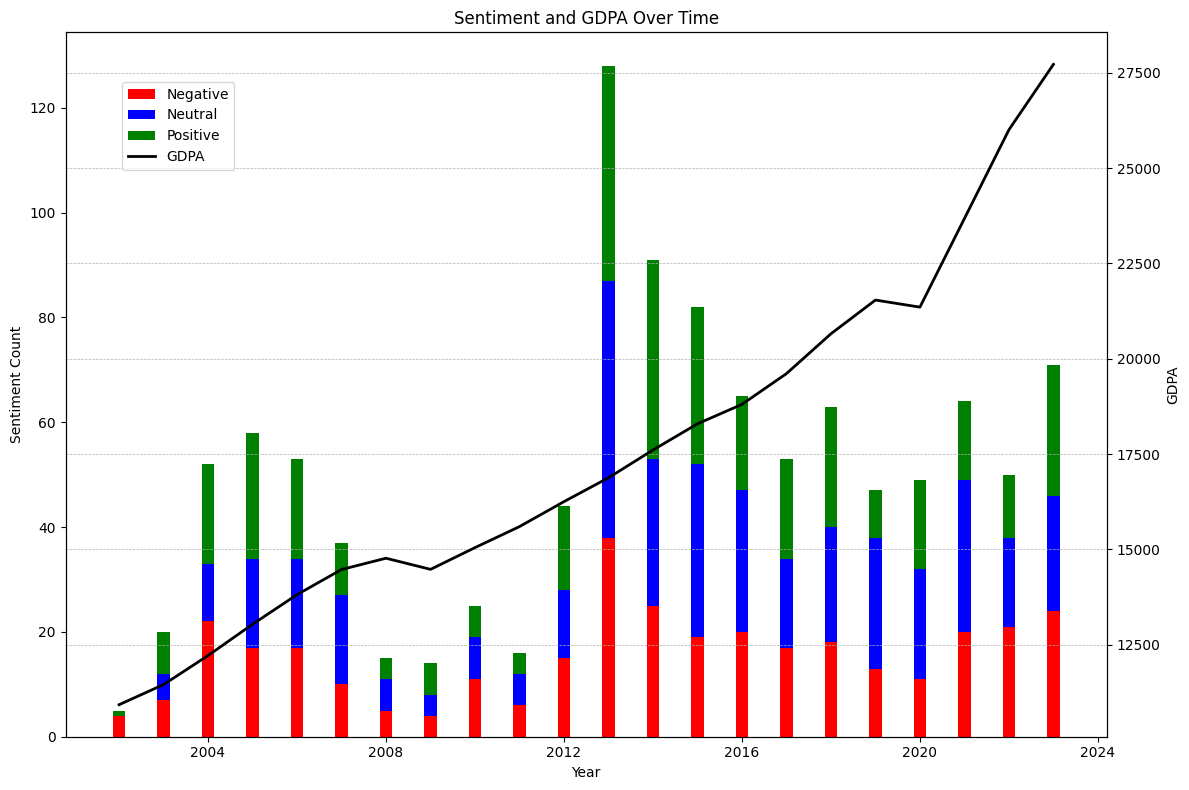

In [ ]:
# plot 2 y-axis of dfsentgdp

import matplotlib.pyplot as plt

# Further increasing bar width for better visibility
bar_width = 100  # Adjusted bar width for more thickness

# Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Stacked bar chart for sentiments with increased bar width
ax1.bar(dfsentgdp.index, dfsentgdp['negative'], label='Negative', color='red', width=bar_width, align='center')
ax1.bar(dfsentgdp.index, dfsentgdp['neutral'], bottom=dfsentgdp['negative'], label='Neutral', color='blue', width=bar_width, align='center')
ax1.bar(dfsentgdp.index, dfsentgdp['positive'], bottom=dfsentgdp['negative'] + dfsentgdp['neutral'], label='Positive', color='green', width=bar_width, align='center')

# Configure ax1
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment Count')
ax1.tick_params(axis='y')
ax1.set_title('Sentiment and GDPA Over Time')

# Line plot for GDPA on secondary axis
ax2 = ax1.twinx()
ax2.plot(dfsentgdp.index, dfsentgdp['GDPA'], label='GDPA', color='black', linewidth=2)
ax2.set_ylabel('GDPA')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Grid and layout
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

